# LSTM Model
As per yidi, need to work on deep learning part of the project. Gonna just try a quick shotgun approach to see what could work

Supposedly would be nice to use the entire segment for LSTM, but lets just use 20 second segments for now

In [1]:
import glob 
import os
import pandas as pd
import statsmodels as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from importlib import reload
from sklearn import model_selection, metrics
from tqdm.auto import tqdm
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from src import main, feature_model

labels1 = pd.read_csv('data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv')
labels2 = pd.read_csv('data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv')

In [7]:
%%bash
ls ../beat_pd/data/real-pd/clinical_data/

REAL-PD_Demographics.csv
REAL-PD_Smartphone_Metadata.csv
REAL-PD_UPDRS_Part1_2_4.csv
REAL-PD_UPDRS_Part3.csv


In [2]:
labels = labels1.dropna()

In [3]:
#lets go and filter data with some utility funcs
from scipy.signal import butter, lfilter

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

# grabs some filter constants for making bandpass filter
#    order is kinda like strength of filter... higher leads to more ideal filter but has weird interactions near the edges of the filter
#    lower is less ideal but results in less artifacts being generated
#    this is a bit of a cheat anyways, using a lowpass and highpass together, there may be less sketch filter designs applicable
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lp_filter(data, lowcut, fs, order=5):
    nyq = 0.5 * fs #just get the highest freq possible (nyquist, and bandgap it!)
    hc = nyq * 0.9 #can't accept exactly nyq
    print("hc:", hc)
    return butter_bandpass_filter(data, lowcut, hyc, fs, order)
def butter_bandgap_filter(data, lowcut, highcut, fs, order=5):
    if highcut is None:
        return butter_bandgap_filter(data, lowcut, fs, order)
    toRemove = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    return data - toRemove
from src.main import read_seq

def get_data(m_id):
    data = pd.read_csv(f"/home/ms994/beat_pd/data/cis-pd/training_data/{m_id}.csv", index_col="Timestamp", header=0)
    return data.set_index(pd.to_timedelta(data.index, unit="s"))
def get_preprocessed_data(measurement_id, low_f=1, high_f=10):
    data = get_data(measurement_id)
    #50 hz, make a bandpass between 1 and 10 hz, with order of 5
    data = butter_bandpass_filter(data, low_f, high_f, 50, 5)
    return data

In [ ]:
all_data = 

## Let's try just using the frequency data

In [4]:
import pickle as pkl
#from the EDA.ipynb
np_x_data = pkl.load(open("/n/scratch2/ms994/beat_pd_frequency_data.pkl", "rb"))
y = pkl.load(open("/n/scratch2/ms994/beat_pd_labels_1s.pkl", "rb"))

In [5]:
np_x_data.shape, y.shape

((2210912, 3, 26), (2210912, 5))

In [6]:
import tensorflow as tf

### Reshape back out into correct shape
I flattened this between measurements originally as a way to run RF on everything, but running this as a sequence may make much more sense.
The way I concatenated everything has maintained order, so I should be able to separate back out while keeping chronological order.

In [8]:
#grab all the measurement ids
m_ids = y.measurement_id.unique()

In [10]:
m_ids.shape #only 963 in here

(963,)

In [36]:
label = labels1.dropna()

In [40]:
label.shape

(963, 5)

In [11]:
reshapedData = []
for m_id in m_ids:
    reshapedData.append(np_x_data[y.measurement_id==m_id])

In [43]:
reshapedData[0].shape[0]

1799

In [46]:
# lets try for 2 minute chunks of data, split into, say, 10 seconds of data with 5 second overlap?
time_reshaped_data = []
time_reshaped_y = []
for i, m_id in enumerate(m_ids):
    max_instances = int(np.floor(reshapedData[i].shape[0]/50 - 1) )
    for j in range(max_instances):
        time_reshaped_data.append(reshapedData[i][j*50:j*50 + 100])
        time_reshaped_y.append(label[label.measurement_id == m_id])

In [48]:
time_reshaped_data = np.array(time_reshaped_data)

In [50]:
time_reshaped_data.shape #lets try 1d cnn

(42707, 100, 3, 26)

looks like it is a correct pad value, nothing in the sequence matches

In [94]:
import sys, os
import tensorflow as tf
sys.path.append(os.path.realpath("/home/ms994/dbmi_eeg_clustering")) #lol, i have a ton of utility classes here
from keras_models.metrics import f1, sensitivity, specificity
num_layers = 2
num_lin_layers= 4
inputX = tf.keras.layers.Input((100,3,26))
x = tf.keras.layers.Reshape((100, 3*26))(inputX)
for i in range(num_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(50, (5,))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
x = tf.keras.layers.CuDNNLSTM(50, return_sequences=True)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Flatten()(x)

for i in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    
x = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
y_on_off = tf.keras.layers.ReLU(max_value=4)(x)

model = tf.keras.Model(inputs=[inputX], outputs=[y_on_off])
model.compile("adam", loss="mse")

In [63]:
labels = pd.concat(time_reshaped_y, axis=0)
labels.head()
y = labels.on_off

In [80]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(labels.measurement_id.unique())
# train, valid = train_test_split(labels.measurement_id.unique())

In [81]:
x_train = time_reshaped_data[labels.measurement_id.isin(train)]
y_train = labels[labels.measurement_id.isin(train)]
x_test = time_reshaped_data[labels.measurement_id.isin(test)]
y_test = labels[labels.measurement_id.isin(test)]
# x_valid = time_reshaped_data[labels.measurement_id.isin(valid)]
# y_valid = labels[labels.measurement_id.isin(valid)]

In [84]:
x_train.shape

(32041, 100, 3, 26)

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100, 3, 26)        0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 100, 78)           0         
_________________________________________________________________
batch_normalization_v1_82 (B (None, 100, 78)           312       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 96, 50)            19550     
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 96, 50)            0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 48, 50)            0         
_________________________________________________________________
batch_normalization_v1_83 (B (None, 48, 50)            200       
__________

In [95]:
history = model.fit(x=x_train, y=y_train.on_off.astype(float).tolist(), validation_split=0.2, epochs=1000, callbacks=[tf.keras.callbacks.EarlyStopping(patience=20), tf.keras.callbacks.ModelCheckpoint("beat_pd.h5", save_best_only=True)])

Train on 25632 samples, validate on 6409 samples
Epoch 1/1000
25632/25632 [==============================] - 27s 1ms/sample - loss: 2.1178 - val_loss: 1.4630
Epoch 2/1000
25632/25632 [==============================] - 14s 551us/sample - loss: 1.9198 - val_loss: 1.3737
Epoch 3/1000
25632/25632 [==============================] - 13s 524us/sample - loss: 1.8765 - val_loss: 1.6006
Epoch 4/1000
25632/25632 [==============================] - 13s 526us/sample - loss: 1.8438 - val_loss: 1.9788
Epoch 5/1000
25632/25632 [==============================] - 14s 527us/sample - loss: 1.8205 - val_loss: 2.6128
Epoch 6/1000
25632/25632 [==============================] - 14s 530us/sample - loss: 1.7894 - val_loss: 1.4262
Epoch 7/1000
25632/25632 [==============================] - 14s 531us/sample - loss: 1.7716 - val_loss: 1.4488
Epoch 8/1000
25632/25632 [==============================] - 14s 535us/sample - loss: 1.7359 - val_loss: 1.1712
Epoch 9/1000
25632/25632 [==============================] - 14s 5

In [96]:
model = tf.keras.models.load_model("beat_pd.h5")

In [97]:
mse = model.evaluate(x_test, y_test.on_off.astype(float).tolist())

10666/10666 [==============================] - 4s 359us/sample - loss: 1.7181


In [101]:
predictions = model.predict(x_test)

In [105]:
y_test.loc[:,"pred"] = predictions

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [112]:
intermediate = y_test.groupby("measurement_id").mean()

In [113]:
intermediate.loc[:,"mse"] = (intermediate.on_off - intermediate.pred)**2

In [115]:
intermediate.groupby("subject_id").mean()

,on_off,dyskinesia,tremor,pred,mse
subject_id,,,,,
1004,1.368421,1.368421,1.105263,1.516270,0.835604
1007,0.910448,0.074627,0.298507,1.207870,1.542110
1019,1.538462,1.000000,1.230769,1.555669,1.706153
1023,2.111111,1.074074,0.407407,1.855543,1.370774
1034,1.181818,1.636364,0.727273,1.456636,1.226834
1038,0.869565,0.173913,1.304348,1.383103,2.607848
1043,1.714286,1.000000,1.428571,1.645065,0.960405
1048,1.807692,2.692308,2.769231,1.646693,0.498008
1049,1.480000,0.880000,1.800000,1.576253,0.848635


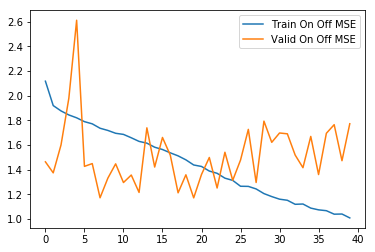

In [100]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train On Off MSE", "Valid On Off MSE"])